#### Use sklearn to fetch MNIST dataset

In [1]:
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

### Scikit-Learn datasets
 - DESCR
     - describing the dataset
 - data
     - (array) ww/one row per instance and one col per feature
 - target
     - labels

In [4]:
imgs, labels = mnist["data"], mnist["target"]
print(imgs.shape)
print(labels.shape)

(70000, 784)
(70000,)


~70k images and each image has 784 features
where each features is a pixel intensity and the img is 28x28

### Inspecting some of the data

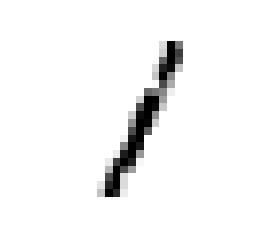

1.0


In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_idx = 12345

some_digit = imgs[some_idx]
some_label = labels[some_idx]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(some_label)

### Partition Dataset
 - Divide into training/test sets
 - Shuffle the indexes so that they aren't all in order

In [6]:
import numpy as np
div_val = 60000
# parition
X_train, X_test, y_train, y_test = imgs[:div_val], imgs[div_val:], labels[:div_val], labels[div_val:]

# shuffle
shuffle_index = np.random.permutation(div_val)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier (6 detector)

### Create relevant values

In [7]:
# y_xxx_6 will contain an array of boolean (true where the value is 6, false everywhere else)
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

# example output
print(y_train_6.shape, y_train_6[11:21])
print(y_test_6.shape, y_test_6[11:21])

(60000,) [False False False False False False False False False False]
(10000,) [False False False False False False False False False False]


### View sample image

In [8]:
# get index where the value is true
key_val = 0
i = 0
for val in y_train_6:
    if val == True:
        key_val = val
        break
    i += 1    
print(i)
print(y_train_6[i])

4
True


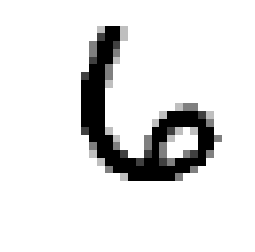

6.0


In [9]:
some_six_digit = X_train[i]
some_six_label = y_train[i]

some_six_digit_reshape = some_six_digit.reshape(28, 28)
plt.imshow(some_six_digit_reshape, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(some_six_label)

#### looks good!

## Training a binary classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
sgd_clf.predict([some_six_digit])

array([ True], dtype=bool)

#### This predicts that the above value is a 6

## Performance Measures

In [12]:
# implementing cross-validation w/our own custom function
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# k-fold cross-validation w/three folds
# -> splitting the training set into k-folds (3 folds),
# making predictions and evaluating each fold
# using the model trained on the remaining folds

for train_index, test_index in skfolds.split(X_train, y_train_6):
    # clone the classifier
    clone_clf = clone(sgd_clf)
    
    # partition folds
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_6[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_6[test_index])

    # train classifier
    clone_clf.fit(X_train_folds, y_train_folds)
    
    # predict
    y_pred = clone_clf.predict(X_test_fold)
    
    # count number of correct predictions
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.98000099995
0.97875
0.979198959948


In [13]:
# use a function to produce the same results
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring="accuracy")

array([ 0.980001  ,  0.97875   ,  0.97919896])

## Here's the catch
> this may look pretty impressive. but let's say our model is predicting '0'/'not 6' every time..  Then, the accuracy would be 90%! since only 1/10th = 10% of the data is a 6

In [14]:
## as an example.. here's a model that classifies each image as 'not-6'
from sklearn.base import BaseEstimator

class Never6Classifier(BaseEstimator):
    def fit(sef, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

    
never_6_classifier = Never6Classifier()
cross_val_score(never_6_classifier, X_train, y_train_6, cv=3, scoring="accuracy")

array([ 0.90065,  0.90255,  0.9009 ])

## Confusion matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, y_train_pred)

array([[53462,   620],
       [  621,  5297]])

### Other metrics
- precision
    - `TP/TP+FP`
- recall (sensitivity or true positive rate)
    - `TP/TP+FN`
    - ratio of positive instances that are correctly detected by the classifier

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score_6 = precision_score(y_train_6, y_train_pred)
recall_score_6 = recall_score(y_train_6, y_train_pred)

print("precision: ",precision_score_6)
print("recall: ",format(recall_score_6))

precision:  0.895217170864
recall:  0.8950659006421088


In [18]:
# F1 = the harmonic mean of precision and recall
# harmonic, in that in a normal mean, all values are treated equally
# the harmonic mean gives more weight to low values.
from sklearn.metrics import f1_score
f1_score(y_train_6, y_train_pred)

0.89514152936206171

In [19]:
# making scores based on custom thresholds
y_scores = sgd_clf.decision_function([some_six_digit])
y_scores

array([ 286925.67615248])

In [20]:
thresh = 0
y_some_digit_pred = (y_scores > thresh)
print(y_some_digit_pred)

[ True]


In [21]:
# get scores of all instances in the training set -> returning decision scores, not predictions
y_proba = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")

In [22]:
# compute precision and recall for all possible threshold using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_proba)

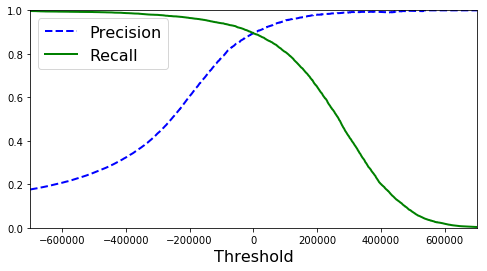

In [23]:
# plot these values
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4)) 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

## Interesting note:
> The precision curve is sometimes bumpy, the reason for this is that the precision can sometimes go down as you move a threshold up. (imaging moving it one value and the value you move is a correct prediction, but now marked incorrectly.  Recall, on the otherhand, can only go down as you move to the right

In [24]:
# let's say someone requests a classifier with 90% precision.
# great, but you should also ask at what recall
#  for instance, ~10000+ all provide ~.90 precision, but as the value gets
# higher, the recall decreases

#example
y_train_pred_90 = (y_proba > 10000)
print(precision_score(y_train_6, y_train_pred_90))

y_train_pred_90 = (y_proba > 500000)
print(precision_score(y_train_6, y_train_pred_90))

0.901816312543
0.997674418605


In [25]:
# but, how are the recalls looking at these values
y_train_pred_90 = (y_proba > 10000)
print(recall_score(y_train_6, y_train_pred_90))

y_train_pred_90 = (y_proba > 500000)
print(recall_score(y_train_6, y_train_pred_90))

0.889320716458
0.0724907063197


## ^ there you have it...

### ROC Curve
- plots true positive rate (sensitivity) against true negative rate (1-specificity)

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_6, y_proba)

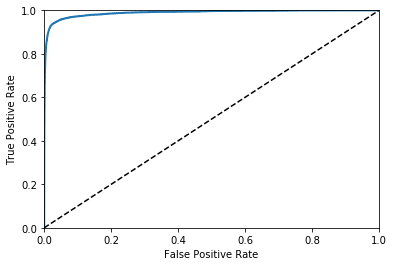

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

### AUC
- area under the curve

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6, y_proba)

0.98855373311369432

## Random Forest Classifier to compare ROC and ROC AUC to SGDClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, y_train_6, 
                                    cv=3, method="predict_proba")

print(y_probas_forest)

[[ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 ..., 
 [ 1.   0. ]
 [ 0.9  0.1]
 [ 1.   0. ]]


In [30]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
print(y_scores_forest)

[ 0.   0.   0.  ...,  0.   0.1  0. ]


In [31]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6, y_scores_forest)

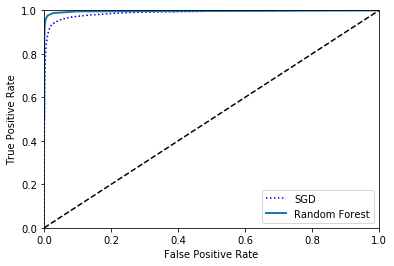

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
print(roc_auc_score(y_train_6, y_proba))
print(roc_auc_score(y_train_6, y_scores_forest))

0.988553733114
0.996407375847


# Multiclass classification
- Using a binary classifier for multiclass
    - OvA, one vs all
        - trains one time for each class (that class vs the rest)
            - 1 vs (not 1), 2 vs (not 2)
    - OvO
        - trains one time for each "pair"
            - 0 vs 1, 0 vs 2, ....
        - where there are _n_ classes, you'd have to train (n x (n-1)/2) classifiers
            - MNIST = 45

In [34]:
# if we use scikit-learn, it tries to detect when we're using a binary classification algorithm
# and will automatically run OvA (except for SVM classifiers)

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_six_digit])

array([ 6.])

^ under the hood, scikit-learn actually trained 10 binary classifiers, 
got their decision scores for the image, then selected the class with the highest score

In [35]:
# the decision function will show us these scores for each classifier
some_digit_scores = sgd_clf.decision_function([some_six_digit])
print(some_digit_scores)

[[ -333598.38353314 -1034798.77581328  -427259.6036519   -673487.87925428
   -613222.32434488  -441906.28123222   286925.67615248  -818236.32214327
   -534979.89544004  -629268.8083275 ]]


In [36]:
np.argmax(some_digit_scores)

6

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

### In this case the classes/values align, but this won't always be the case
We're predicting that the image is a 0.  This is understandable given the original image

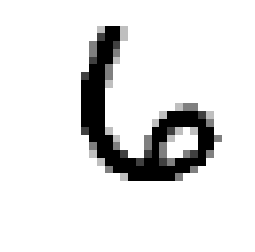

6.0


In [38]:
some_six_digit_reshape = some_six_digit.reshape(28, 28)
plt.imshow(some_six_digit_reshape, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(some_six_label)

In [39]:
### what if we want to use a one vs one approach
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_six_digit])

array([ 6.])

In [40]:
len(ovo_clf.estimators_)

45

### Random Forest

In [41]:
# random forests don't have to run OvA or OvO since they can directly
# classify multi-class
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_six_digit])

array([ 6.])

### In this case, the classification was made correctly

In [42]:
print("number estimators: ",len(forest_clf.estimators_))
forest_scores = forest_clf.predict_proba([some_six_digit])
print("forest proba: ", forest_scores)
print("number classes: ",forest_clf.classes_)

number estimators:  10
forest proba:  [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
number classes:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


#### you can see that class `6` (correct) had the highest value, followed by 0, as expected

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85087982,  0.86904345,  0.86898035])

this achieves > 85% accuracy on all folds. this is quite good --- if we rand a random classifier, we'd see ~10% accuracy

#### Scaling the inputs to increase acccuracy

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91006799,  0.90644532,  0.91128669])

# Error Analysis

### Confusion Matrix

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[5736,    3,   21,    9,   11,   47,   44,    8,   41,    3],
       [   1, 6476,   49,   24,    6,   37,    8,   13,  119,    9],
       [  55,   42, 5322,  106,   75,   23,   87,   66,  162,   20],
       [  52,   39,  143, 5362,    2,  219,   33,   57,  135,   89],
       [  18,   28,   40,    7, 5356,   10,   53,   33,   81,  216],
       [  74,   39,   36,  185,   75, 4600,  113,   28,  178,   93],
       [  35,   25,   48,    2,   45,   89, 5627,    5,   42,    0],
       [  27,   25,   63,   33,   55,    9,    5, 5786,   15,  247],
       [  47,  158,   66,  156,   14,  154,   56,   23, 5022,  155],
       [  39,   38,   23,   89,  159,   34,    2,  210,   86, 5269]])

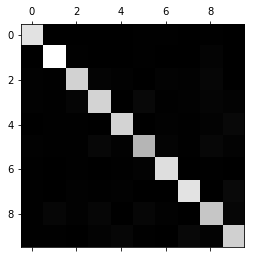

In [46]:
# create image representation of confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

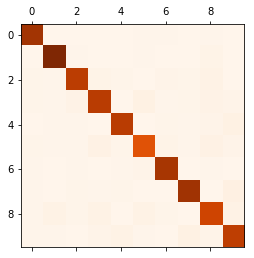

In [47]:
# different mapping of the original confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.Oranges)
plt.show()

### looking more closely at the plot errors
First: divide each value by the number of images in the corresponding class so that we can compare error rates.

In [48]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = conf_matrix / row_sums

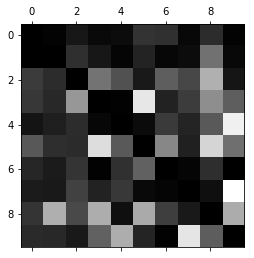

In [49]:
# fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

This shows the types of errors that are commonly made, where brighter=more errors.
- rows = represent actual classes
- columns = represent predicted classes

The column for 8 is pretty bright -- meaning, it looks like 8's are commonly misclassified as other digits

some rows are pretty dark (row 1) - meaning most 1's are classified correctly

Note: errors are not perfectly symetrical

The confusion matrix can help us determine where/how we should spend our time to try and improve performance (8's and 9's) as well as the specific (3 vs 5).
options;
- gather more training data (specifically for these images)
- engineer new features that would aid the classifier
    - algorithm to count the number of closed loops
- preprocess the images
    - make some patterns (maybe closed loops) stand out more

In [50]:
# taken directly from https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

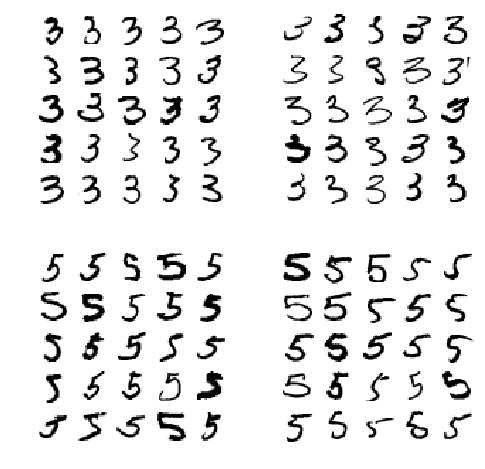

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

blocks on the left = digits classified as 3's

blocks on the right = digits classified as 5's

### Understanding this 3/5 confusion
The classifier we used was a simple SGDClassifier, it works by assigning a weight per class to each pixel then when it sees a new image, it sums up all the weighted pixel intensities to get a score for each class... In this case, 3/5 differ by only a few pixels and so the model could easily confuse them.

One way to help account for this confusion could be to preprocess the images to ensure they are well centered and not rotated.

# Multilabel classification

In [52]:
from sklearn.neighbors import KNeighborsClassifier

# new labels. large and odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
knn_clf.predict([some_six_digit])

array([[False, False]], dtype=bool)

^ This is saying, that 6 is *not* large, and that is is *not* odd -- which is correct in this case

### How to evaluate performance on multi-class?
- one approach is to measure the F1 score for each individual lable, then compute the average score

In [ ]:
# this takes a long time to run
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

#### NOTE: this assumes that all labels are equally important.
to account for this, we can give each label a weight

In [ ]:
f1_score(y_train, y_train_knn_pred, average="average")

^ in this case, the result wouldn't be different since all the classes have the same weights

## Multioutput Classification
> "generalization of multilabel classification where each label can be multiclass -> it can have more than two possible values"

### Example
build system to remove noise from images.
- input: noisy image
- output: clean image
> classifier output is is multilable (one label per pixel), and that each label can have multiple values (0-255) --> 'multioutput classification' system.

Note:
classification/regression distinction is sometimes blurry (like in this case).
- predicting pixel intensity is ~regression than classification
- multioutput systems are note limited to classification tasks
    - could have a system that outputs multiple labels per instance, including both class labels and value labels.

In [59]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [61]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

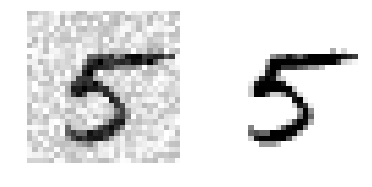

In [62]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

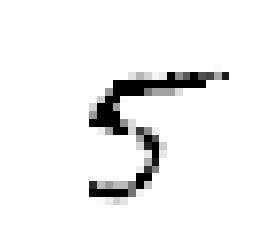

In [63]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)